In [1]:
import torch
import glob
import numpy as np
from collections import namedtuple
from tqdm import tqdm
import seaborn as sns

import SimpleITK as sitk

from models import networks
import os
from os import path as osp
from copy import deepcopy
from matplotlib import pyplot as plt

from data.copdslice2class_dataset import Copdslice2classDataset

In [2]:
# namedtuple('Struct', 'a b c')
net = networks.ResnetGenerator(1, 1, ngf=32, norm_layer=networks.get_norm_layer('batch')
                               , use_dropout=False, n_blocks=6, num_patches=0)

In [3]:
path = '/ocean/projects/asc170022p/rohit33/cyclegan_models/checkpoints/copd_emphysema_slice_resnet6_2parts_small_noslice'
dataroot = '/ocean/projects/asc170022p/rohit33/COPDslices/'

In [4]:
path

'/ocean/projects/asc170022p/rohit33/cyclegan_models/checkpoints/copd_emphysema_slice_resnet6_2parts_small_noslice'

In [5]:
checkpoint = 112500
use_ckpt = True
if use_ckpt:
    ga_path = osp.join(path, 'iter_{}_net_G_A.pth'.format(checkpoint))
    gb_path = osp.join(path, 'iter_{}_net_G_B.pth'.format(checkpoint))

In [6]:
net_A = deepcopy(net).cuda()
net_B = deepcopy(net).cuda()

In [7]:
net_A.load_state_dict(torch.load(ga_path))
net_B.load_state_dict(torch.load(gb_path))

<All keys matched successfully>

In [8]:
# Create argument dict
Arg = namedtuple('Arg', 'dataroot use_nan patchfloat frac')
arg = Arg(dataroot=dataroot, use_nan=False, patchfloat=0, frac=0.2)
ds = Copdslice2classDataset(arg)

In [35]:
idx = 15000

In [36]:
data = ds[idx]

In [37]:
with torch.no_grad():
    fake_b = net_A(torch.FloatTensor(data['A'][None] + 0).cuda())
    rec_a = net_B(fake_b)

    fake_a = net_A(torch.FloatTensor(data['B'][None] + 0).cuda())
    rec_b = net_B(fake_a)

(-0.5, 447.5, 447.5, -0.5)

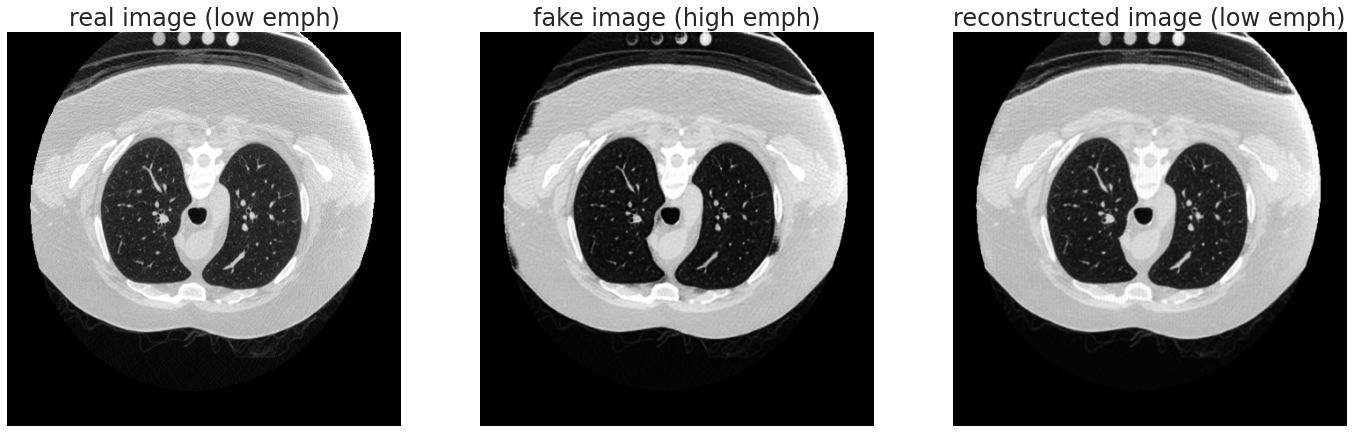

In [57]:
sns.set(font_scale=2)
plt.figure(figsize=(24, 8))
plt.subplot(131)
plt.imshow(data['A'][0], 'gray')
plt.title('real image (low emph)')
plt.axis('off')
plt.subplot(132)
plt.imshow(fake_b[0, 0].data.cpu().numpy(), 'gray')
plt.title('fake image (high emph)')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_a[0, 0].data.cpu().numpy(), 'gray')
plt.title('reconstructed image (low emph)')
plt.axis('off')

(-0.5, 447.5, 447.5, -0.5)

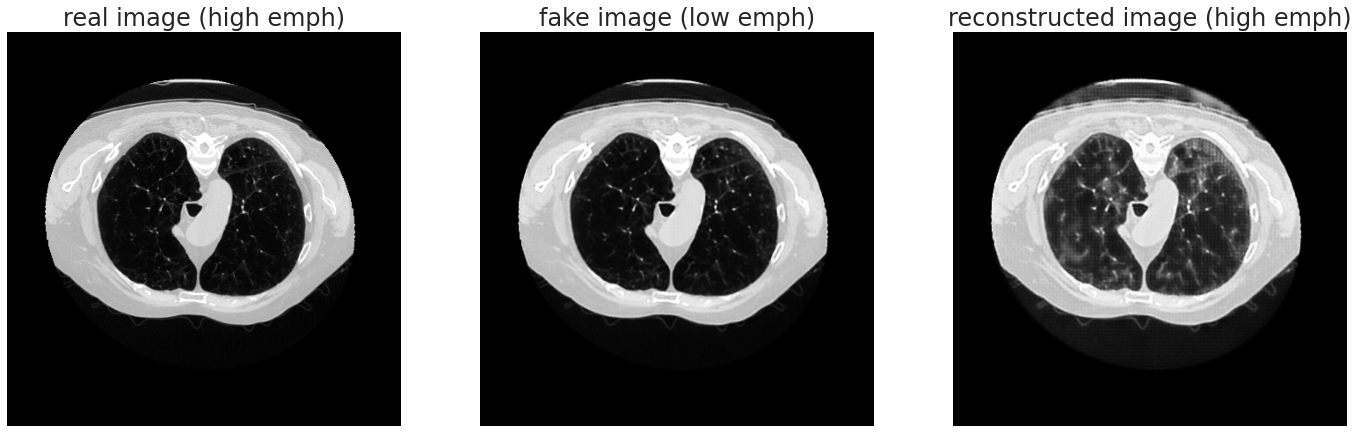

In [58]:
plt.figure(figsize=(24, 8))
plt.subplot(131)
plt.imshow(data['B'][0], 'gray')
plt.title('real image (high emph)')
plt.axis('off')
plt.subplot(132)
plt.imshow(fake_a[0, 0].data.cpu().numpy(), 'gray')
plt.title('fake image (low emph)')
plt.axis('off')
plt.subplot(133)
plt.imshow(rec_b[0, 0].data.cpu().numpy(), 'gray')
plt.title('reconstructed image (high emph)')
plt.axis('off')

In [38]:
data['A_paths']

'/ocean/projects/asc170022p/rohit33/COPDslices/slices/20928S_234.npy'

## Get a full fake volume (A to B)

Use the data paths to get full volume (in a batch)?

In [39]:
def pad(img):
    H, W = img.shape
    imgn = np.zeros((448, 448)) - 1
    imgn[:H, :W] = img + 0
    return imgn
    
def normalize(img):
    m = img.min()
    M = img.max()
    return 2*(img - m)/(M - m + 1e-10) - 1

def get_volume(path):
    prefix = path.split('_')[0]
    vol = []
    for i in tqdm(range(379)):
        p = prefix + '_{}.npy'.format(i)
        img = np.load(p)
        img = np.clip(img, -1024, 240)
        img = normalize(img)
        img = pad(img)
        vol.append(img)
    return np.array(vol)

In [40]:
vol_A = get_volume(data['A_paths'])

100%|██████████| 379/379 [00:14<00:00, 25.96it/s]


In [41]:
fake_vol_B = []
with torch.no_grad():
    input_A = torch.FloatTensor(vol_A).unsqueeze(1).cuda() + 0
    print(input_A.shape)
    for i in tqdm(range(input_A.shape[0])):
        fake_vol_B.append(net_A(input_A[i].unsqueeze(0)).to('cuda:0'))
        
rec_vol_A = []
with torch.no_grad():
    for i in tqdm(range(len(fake_vol_B))):
        rec_vol_A.append(net_B(fake_vol_B[i].to('cuda:0')).to('cuda:0'))

  5%|▍         | 18/379 [00:00<00:02, 177.51it/s]

torch.Size([379, 1, 448, 448])


100%|██████████| 379/379 [00:03<00:00, 95.31it/s]


In [42]:
fake_vol_B = torch.cat(fake_vol_B, 0).cpu().squeeze()
print(fake_vol_B.shape)

torch.Size([379, 448, 448])


In [43]:
rec_vol_A = torch.cat(rec_vol_A, 0).cpu().squeeze()
print(rec_vol_A.shape)

torch.Size([379, 448, 448])


In [44]:
# Get mask first
def get_mask(path):
    sid = path.split('_')[0].split('/')[-1]
    print(sid)
    subfile = '{}_INSP_STD_*'.format(sid)
    path = osp.join('/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/unet_mask_transformed', subfile)
    path = glob.glob(path)[0]
    print(path)
    mask = sitk.GetArrayFromImage(sitk.ReadImage(path))
    C, H, W = mask.shape
    maskn = np.zeros((C, 448, 448))
    maskn[:, :H, :W] = mask
    return maskn

In [45]:
mask_A = get_mask(data['A_paths'])

20928S
/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/unet_mask_transformed/20928S_INSP_STD_HAR_COPD_Reg_19676E_Affine.nii.gz


In [46]:
def get_emphysema(img, mask):
    M = 240
    m = -1024
    thres = (-950 - m)/(M - m)*2 - 1
    emphcount = (img <= thres)*(mask > 0)
    return emphcount.astype(float).mean() / (mask > 0).astype(float).mean()

In [47]:
print(get_emphysema(vol_A, mask_A))

0.0003110616501026338


In [48]:
print(get_emphysema(fake_vol_B.numpy(), mask_A))

0.2592864311929975


In [49]:
print(get_emphysema(rec_vol_A.numpy(), mask_A))

0.011174558863288074


## Get a full fake volume (B to A)

Use the data paths to get full volume 

In [50]:
vol_B = get_volume(data['B_paths'])

100%|██████████| 379/379 [00:15<00:00, 23.84it/s]


In [51]:
fake_vol_A = []
with torch.no_grad():
    input_B = torch.FloatTensor(vol_B).unsqueeze(1).cuda() + 0
    print(input_B.shape)
    for i in tqdm(range(input_B.shape[0])):
        fake_vol_A.append(net_B(input_B[i].unsqueeze(0)).to('cuda:0'))
        
rec_vol_B = []
with torch.no_grad():
    for i in tqdm(range(len(fake_vol_A))):
        rec_vol_B.append(net_A(fake_vol_A[i].to('cuda:0')).to('cuda:0'))

  5%|▍         | 18/379 [00:00<00:02, 179.53it/s]

torch.Size([379, 1, 448, 448])


100%|██████████| 379/379 [00:03<00:00, 95.32it/s]


In [52]:
fake_vol_A = torch.cat(fake_vol_A, 0).squeeze().cpu()

rec_vol_B = torch.cat(rec_vol_B, 0).squeeze().cpu()

In [53]:
mask_B = get_mask(data['B_paths'])

14950Z
/ocean/projects/asc170022p/lisun/registration/INSP2Atlas/unet_mask_transformed/14950Z_INSP_STD_DUK_COPD_Reg_19676E_Affine.nii.gz


In [54]:
print(get_emphysema(vol_B, mask_B))

0.2876806330379417


In [55]:
print(get_emphysema(fake_vol_A.numpy(), mask_B))

0.005404296893071552


In [56]:
print(get_emphysema(rec_vol_B.numpy(), mask_B))

0.19458729989471718
